In [30]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [45]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Please tell me how can I help you?",name="LLModel")]
messages.append(HumanMessage(content=f"I want to leanrn coding",name="Deepak"))
messages.append(AIMessage(content=f"Which programming language you want to learn?",name="LLModel"))
messages.append(HumanMessage(content=f"I want to learn Python for GenAI",name="Deepak"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLModel

Please tell me how can I help you?
================================ Human Message =================================
Name: Deepak

I want to leanrn coding
================================== Ai Message ==================================
Name: LLModel

Which programming language you want to learn?
================================ Human Message =================================
Name: Deepak

I want to learn Python for GenAI


In [49]:
from langchain_groq import ChatGroq

llm_groq = ChatGroq(model="llama-3.3-70b-versatile")
llm_groq.invoke(messages)

AIMessage(content='Python is a fantastic language for GenAI (Generative AI) and a popular choice among developers and researchers. Here\'s a step-by-step guide to help you get started:\n\n**Prerequisites**\n\n1. Basic understanding of programming concepts (variables, data types, loops, conditional statements)\n2. Familiarity with mathematical concepts (linear algebra, calculus, probability)\n\n**Learning Resources**\n\n1. **Online Courses**:\n\t* Codecademy\'s Python Course (interactive coding environment)\n\t* Python for Everybody (Coursera)\n\t* Python Data Structures (Coursera)\n2. **Books**:\n\t* "Python Crash Course" by Eric Matthes\n\t* "Automate the Boring Stuff with Python" by Al Sweigart\n\t* "Python for Data Analysis" by Wes McKinney\n3. **Tutorials and Guides**:\n\t* Official Python Documentation (python.org)\n\t* Real Python (realpython.com)\n\t* W3Schools\' Python Tutorial (w3schools.com)\n\n**GenAI-specific Resources**\n\n1. **Libraries and Frameworks**:\n\t* TensorFlow (

In [37]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
         a (int): first input
         b (int): second input

    Returns:
         int 
    """
    return a+b

In [50]:
### binding tool with llm

llm_with_tools = llm_groq.bind_tools([add])
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 15",name="Deepak")])

tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9nc1h9cn2', 'function': {'arguments': '{"a":2,"b":15}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 258, 'total_tokens': 273, 'completion_time': 0.054545455, 'prompt_time': 0.013198673, 'queue_time': 0.051896316000000005, 'total_time': 0.067744128}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--98fa0f1e-d926-4ccd-b7e4-895f8ba4ae67-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 15}, 'id': '9nc1h9cn2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 258, 'output_tokens': 15, 'total_tokens': 273})

In [39]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 15},
  'id': 'rzyfdfqce',
  'type': 'tool_call'}]

In [51]:
### binding tool with llm

llm_with_tools = llm_groq.bind_tools([add])
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is Generative AI",name="Deepak")])

tool_call

AIMessage(content='Generative AI refers to a type of artificial intelligence that is capable of generating new, original content, such as text, images, music, or videos, based on a given set of parameters or inputs. This is achieved through the use of complex algorithms and machine learning models, such as generative adversarial networks (GANs) and variational autoencoders (VAEs), which are trained on large datasets and can learn patterns and relationships within the data.\n\nGenerative AI has many potential applications, including:\n\n1. Art and design: Generative AI can be used to create original artwork, music, and other creative content.\n2. Data augmentation: Generative AI can be used to generate new data samples that can be used to augment existing datasets, potentially improving the accuracy of machine learning models.\n3. Content generation: Generative AI can be used to generate text, such as articles, stories, or dialogues, or to create videos, such as animations or special ef

In [8]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

# list, tuple, dictionary

In [9]:
# chatbot node functionality

def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

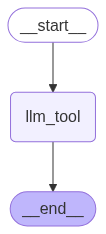

In [10]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
## invocation

messages = graph.invoke({"messages":"What is 2 plus 15"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 15
================================== Ai Message ==================================
Tool Calls:
  add (qc1a4vcc1)
 Call ID: qc1a4vcc1
  Args:
    a: 2
    b: 15
================================= Tool Message =================================
Name: add

17


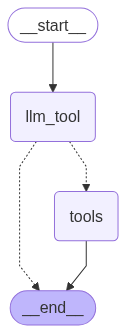

In [26]:
from langgraph.prebuilt import ToolNode,tools_condition

tools = [add]
builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
## invocation

messages = graph.invoke({"messages":"What is 2 plus 15"})
print(messages)

for message in messages["messages"]:
    message.pretty_print()

{'messages': [HumanMessage(content='What is 2 plus 15', additional_kwargs={}, response_metadata={}, id='cedcf714-5cef-4c77-a5d3-ec395e4ebaee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '06ynta59n', 'function': {'arguments': '{"a":2,"b":15}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 985, 'total_tokens': 1072, 'completion_time': 0.158181818, 'prompt_time': 0.107490681, 'queue_time': 0.46067696699999994, 'total_time': 0.265672499}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--28ab95d2-6fd7-4cd9-b041-371f20be4b4d-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 15}, 'id': '06ynta59n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 985, 'output_tokens': 87, 'total_tokens': 1072}), ToolMessage(content='17', name='add', id='167aaf87-29e3-4c7a-a34e-5843228b924d', tool_call_id='06ynta59n')]}
=============

In [41]:
## invocation

messages = graph.invoke({"messages":"What is Generative AI"})
print(messages)

for message in messages["messages"]:
    message.pretty_print()

{'messages': [HumanMessage(content='What is Generative AI', additional_kwargs={}, response_metadata={}, id='ebbc52f8-f663-48e1-a76e-bac60ccb346b'), AIMessage(content='Generative AI refers to a type of artificial intelligence that is capable of generating new, original content, such as images, videos, music, text, and more. This is achieved through complex algorithms and statistical models that allow the AI to learn patterns and relationships within a given dataset, and then use that knowledge to create new, unique outputs.\n\nGenerative AI has a wide range of applications, including:\n\n1. Art and design: Generative AI can be used to create original artwork, designs, and other creative content.\n2. Music and audio: Generative AI can be used to create original music, sound effects, and other audio content.\n3. Text and language: Generative AI can be used to generate original text, such as articles, stories, and dialogue.\n4. Image and video: Generative AI can be used to generate origina